In [1]:
import numpy as np
import matplotlib.pyplot as plt

from cvt_utils import SpaceIterMesh
from plot_utils import display_plots, plot_cell_size_and_density, plot_seeds_and_cells, plot_bound_paths, display_animation, plot_computed_cell_size

plt.style.use("dark_background")
np.random.seed(23)

# Problem definition
x_min = 0.0
x_max = 1.0
dx_min = 1.0e-5
# n_cells = 50
n_cells = 100
# n_iters = 300
# n_iters = 1000
# n_iters = 1010
# n_iters = 2000
# n_iters = 5000
# n_iters = 6000
# n_iters = 7000
# n_iters = 10_000
n_iters = 15_000

mesh = SpaceIterMesh(x_min, x_max, n_cells, n_iters)

# Cell size function
# mesh.cell_size = lambda x: 1.0 + 0.0 * x
# mesh.cell_size = lambda x: np.exp(2*x)
# mesh.cell_size = lambda x: 0.51 + 0.5 * np.sin(2 * np.pi * x)
mesh.cell_size = lambda x: 0.5025 + 0.5 * np.sin(2 * np.pi * (x - 0.05))

# Check cell size function
x = np.linspace(x_min, x_max, 1000) 
assert np.all(mesh.cell_size(x) > dx_min), "Cell size must be positive"

Cell size stats:
min: 0.0025
max: 1.0025
mean: 0.502
std: 0.353

Cell density min: 0.998
Cell density max: 399.937
Cell density mean: 19.958
Cell density std: 60.022


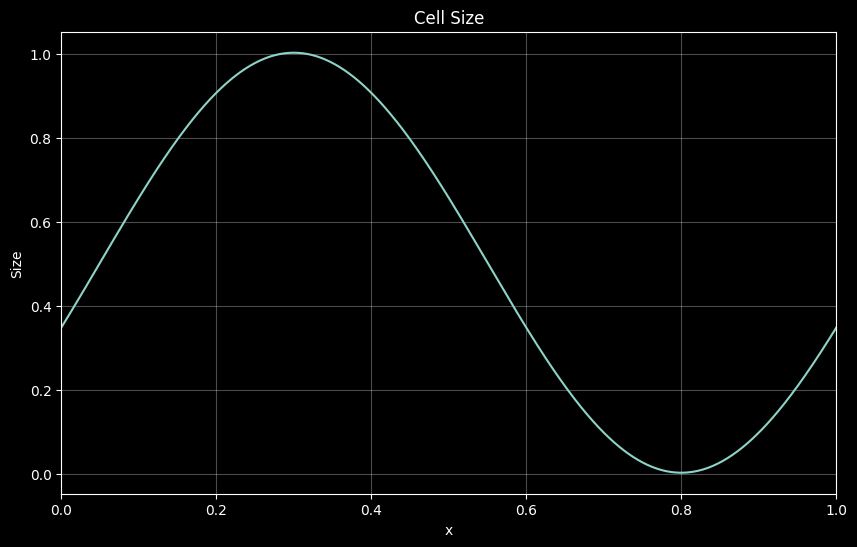

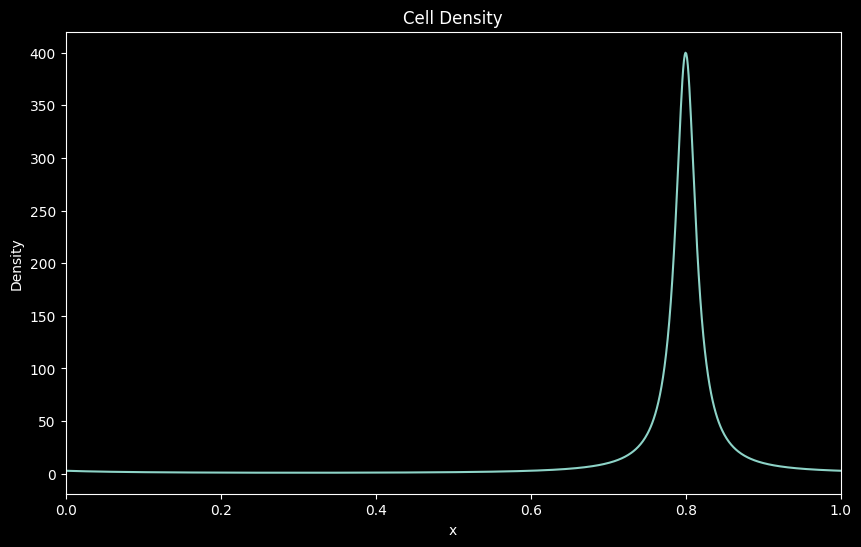

In [2]:
# Print cell size statistics
x = np.linspace(x_min, x_max, 1000)
assert mesh.cell_size is not None, "Cell size function not set"
print("Cell size stats:")
print(f"min: {np.min(mesh.cell_size(x)):.4f}")
print(f"max: {np.max(mesh.cell_size(x)):.4f}") # Should be 0.505 
print(f"mean: {np.mean(mesh.cell_size(x)):.3f}")
print(f"std: {np.std(mesh.cell_size(x)):.3f}")

# Print cell density statistics
print()
print(f"Cell density min: {np.min(mesh.density(x)):.3f}")
print(f"Cell density max: {np.max(mesh.density(x)):.3f}")
print(f"Cell density mean: {np.mean(mesh.density(x)):.3f}")
print(f"Cell density std: {np.std(mesh.density(x)):.3f}")

# Plot cell size and density
plot_cell_size_and_density(mesh)

### Iterations

In [3]:
mesh.set_initial_conditions()
mesh.set_boundary_conditions()

min_iter_step = 10
max_iter_step = 5000

# n_lloyd_iters = min(5000, n_iters)
n_lloyd_iters = min(1000, n_iters)
for iter in range(n_iters):
    mesh.update_cell_bounds(iter)
    mesh.update_cell_masses(iter)
    mesh.update_cell_moments(iter)
    mesh.update_cell_centroids(iter)
    
    if iter >= n_iters - 1:
        break

    if n_lloyd_iters > 0:
        mesh.update_cell_seeds(iter)
        n_lloyd_iters -= 1
    else:
        # Gradually increase the iteration step
        iter_step = min_iter_step + (max_iter_step - min_iter_step) * (iter / n_iters)
        if iter > 0:
            converged = mesh.update_cell_seeds_1st_Ord(iter, iter_step=int(iter_step))
        else:
            converged = mesh.update_cell_seeds_2nd_Ord(iter, iter_step=int(iter_step))
        # converged = mesh.update_cell_seeds_aitken(iter)
        if converged:
            break
        # n_lloyd_iters += 100
        n_lloyd_iters += 1000

In [4]:
# html = display_animation(mesh, duration=4.0, fps=60)
# html

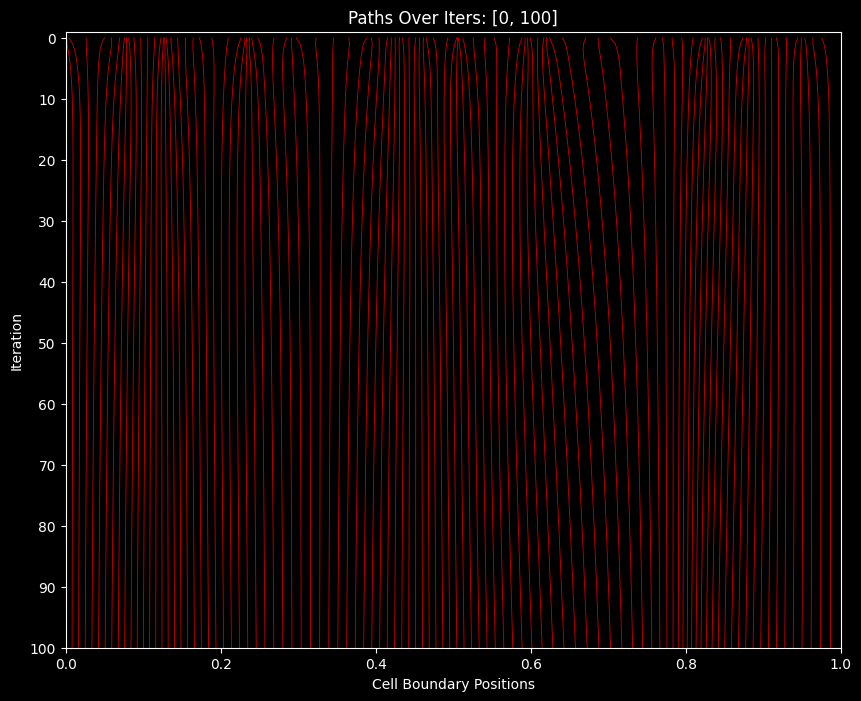

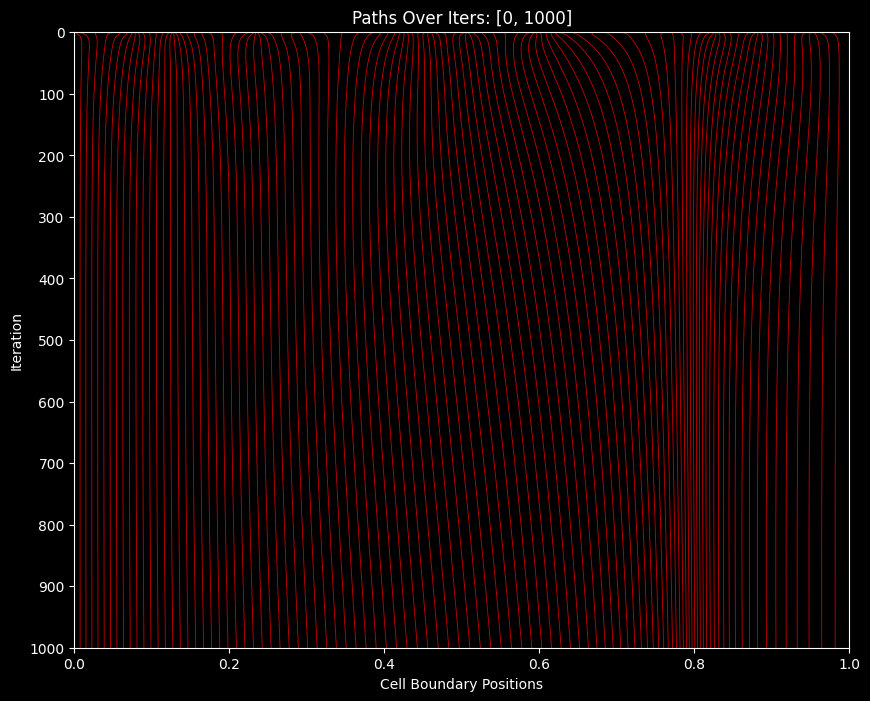

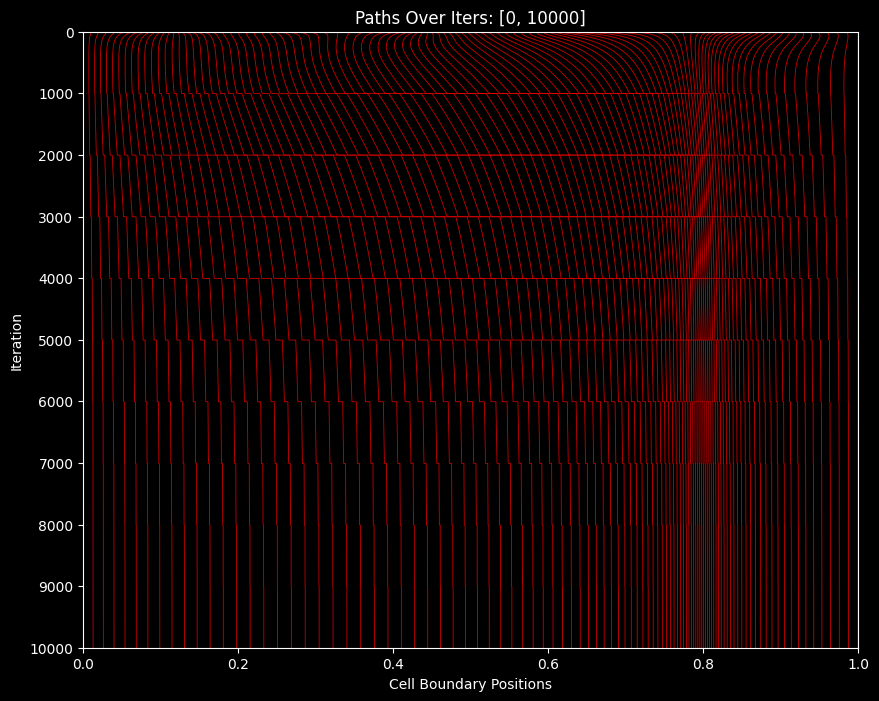

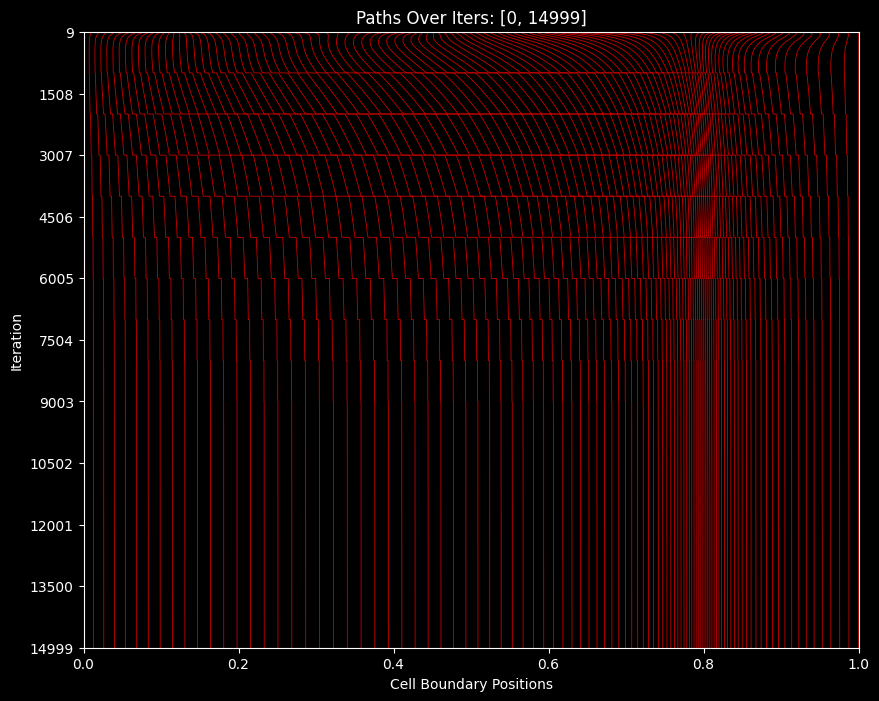

In [5]:
plot_bound_paths(mesh, 0, 100)
plot_bound_paths(mesh, 0, 1000)
plot_bound_paths(mesh, 0, 10000)
# plot_bound_paths(mesh, 0, n_iters - 1)
# plot_bound_paths(mesh, 99, 110)
plot_bound_paths(mesh, 0, n_iters - 1)

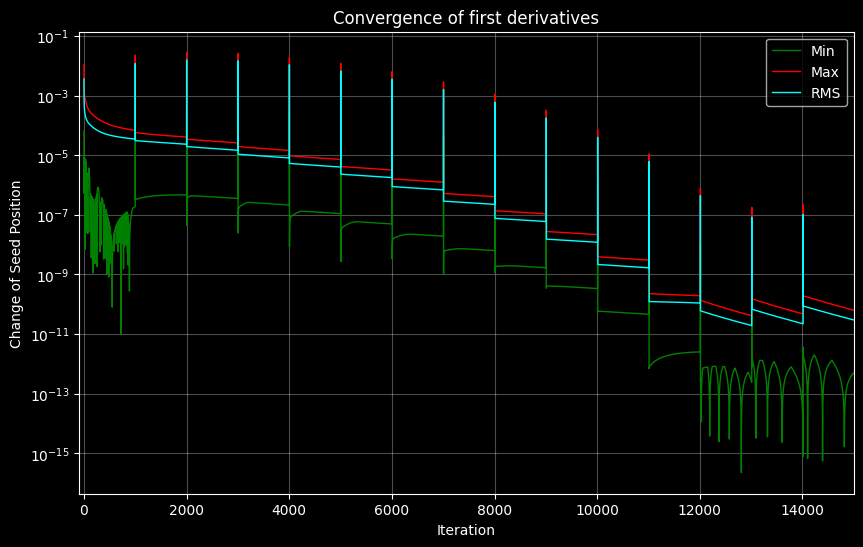

In [6]:
# Compute first derivative of the seed positions over iterations (dx/di = dx)
dseed_matrix = np.diff(mesh.seed_matrix, axis=0)

# Plot the min, max, RMS, and std of the first derivative of the seed positions over iterations
min_dseed = np.min(np.abs(dseed_matrix), axis=1)
max_dseed = np.max(np.abs(dseed_matrix), axis=1)
rms_dseed = np.sqrt(np.mean(dseed_matrix**2, axis=1))

display_plots([
    {"args": (min_dseed, ), "kwargs": {"label": "Min", "linewidth": 1, "color": "green"}},
    {"args": (max_dseed, ), "kwargs": {"label": "Max", "linewidth": 1, "color": "red"}},
    {"args": (rms_dseed, ), "kwargs": {"label": "RMS", "linewidth": 1, "color": "cyan"}},
], "Convergence of first derivatives", "Iteration", "Change of Seed Position", ylog=True, xlims=(-100, n_iters))

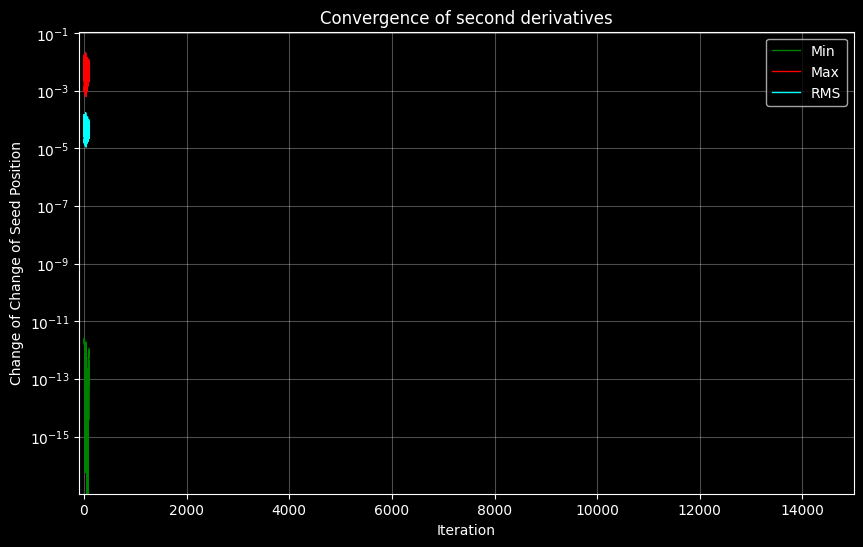

In [7]:
# Compute second derivative of the seed positions over iterations
d2seed_matrix = np.diff(dseed_matrix, axis=1)

# Plot the min, max, and RMS of the second derivative of the seed positions over iterations
min_d2seed = np.min(np.abs(d2seed_matrix), axis=0)
max_d2seed = np.max(np.abs(d2seed_matrix), axis=0)
rms_d2seed = np.sqrt(np.mean(d2seed_matrix**2, axis=0))

display_plots([
    {"args": (min_d2seed, ), "kwargs": {"label": "Min", "linewidth": 1, "color": "green"}},
    {"args": (max_d2seed, ), "kwargs": {"label": "Max", "linewidth": 1, "color": "red"}},
    {"args": (rms_d2seed, ), "kwargs": {"label": "RMS", "linewidth": 1, "color": "cyan"}},
], "Convergence of second derivatives", "Iteration", "Change of Change of Seed Position", ylog=True, xlims=(-100, n_iters))

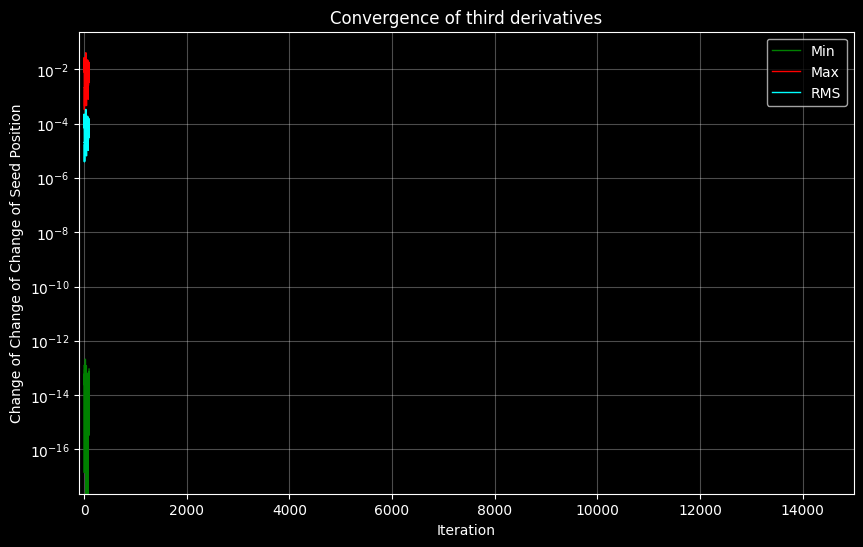

In [8]:
# Compute third derivative of the seed positions over iterations
d3seed_matrix = np.diff(d2seed_matrix, axis=1)

# Plot the min, max, and RMS of the third derivative of the seed positions over iterations
min_d3seed = np.min(np.abs(d3seed_matrix), axis=0)
max_d3seed = np.max(np.abs(d3seed_matrix), axis=0)
rms_d3seed = np.sqrt(np.mean(d3seed_matrix**2, axis=0))

display_plots([
    {"args": (min_d3seed, ), "kwargs": {"label": "Min", "linewidth": 1, "color": "green"}},
    {"args": (max_d3seed, ), "kwargs": {"label": "Max", "linewidth": 1, "color": "red"}},
    {"args": (rms_d3seed, ), "kwargs": {"label": "RMS", "linewidth": 1, "color": "cyan"}},
], "Convergence of third derivatives", "Iteration", "Change of Change of Change of Seed Position", ylog=True, xlims=(-100, n_iters))

In [9]:
plot_computed_cell_size(mesh)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

### Energy

In [ ]:
# Compute total energy per iteration on a log scale
total_energy = mesh.total_energy()

In [ ]:
# Plot total energy
display_plots([
    {"args": (np.sqrt(total_energy), ), "kwargs": {"label": "Total Energy", "linewidth": 1, "color": "cyan"}},
], "Total Energy Over Iterations", "Iteration", "Total Energy", ylog=10, xlims=(-100, n_iters))